In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
from nb_utils import read_params, filter_paths, sweepable_params, parse_logs
import operator as op


# **14 oct**

## large scale run with all augs and video compression


In [2]:
def filter_dataframes(data_dict, criteria_list, mean_over_last=5):
    """
    Filters a dictionary of DataFrames based on multiple conditions for the last 'mean_over_last' values of specified columns.
    Args:
    data_dict (dict): A dictionary where keys are identifiers and values are pandas DataFrames.
    criteria_list (list of tuples): Each tuple contains (column_name, operator, threshold).
    mean_over_last (int): Number of last entries to consider for calculating the mean.
    Returns:
    dict: A filtered dictionary of DataFrames.
    """
    # Mapping of operator symbols to actual functions
    operators = {
        '<': op.lt,
        '>': op.gt,
        '<=': op.le,
        '>=': op.ge,
        '==': op.eq,
        '!=': op.ne
    }
    filtered_dict = {}
    for key, df in data_dict.items():
        meets_all_criteria = True
        for column_name, operator, threshold in criteria_list:
            if column_name in df.columns:
                column_mean_last = df[column_name].tail(mean_over_last).mean()
                # Get the operator function based on the symbol
                func = operators.get(operator)
                # Evaluate the condition
                if not func(column_mean_last, threshold):
                    meets_all_criteria = False
                    break
            else:
                meets_all_criteria = False
                break
        
        if meets_all_criteria:
            filtered_dict[key] = df
    return filtered_dict

lambda_d: [0.0, 0.5]
lambda_i: [0.0, 0.5]
optimizer: ['AdamW,lr=1e-4', 'AdamW,lr=1e-5']
videowam_step_size: [4.0, 16.0]
video_start: [0.0, 500.0]
embedder_model: ['hidden', 'unet_small2', 'unet_very_tiny', 'vae_very_tiny', 'unet_small2_bw', 'unet_very_tiny_bw', 'vae_very_tiny_bw']
output_dir: ['/checkpoint/hadyelsahar/2024_logs/1016-hybrid-vs-ours/_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=hidden', '/checkpoint/hadyelsahar/2024_logs/1016-hybrid-vs-ours/_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=unet_small2', '/checkpoint/hadyelsahar/2024_logs/1016-hybrid-vs-ours/_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=unet_very_tiny', '/checkpoint/hadyelsahar/2024_logs/1016-hybrid-vs-ours/_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=vae_very_tiny', '/checkpoint/hadyelsahar/

_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=16_video_start=0_embedder_model=unet_very_tiny is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=16_video_start=0_embedder_model=vae_very_tiny is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=16_video_start=0_embedder_model=unet_small2_bw is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=16_video_start=0_embedder_model=unet_very_tiny_bw is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=16_video_start=0_embedder_model=vae_very_tiny_bw is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=16_video_start=500_embedder_model=unet_very_tiny is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=16_video_start=500_embedder_model=vae_very_tiny is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=16_video_star

/tmp/ipykernel_1880351/2832707743.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('tab20')


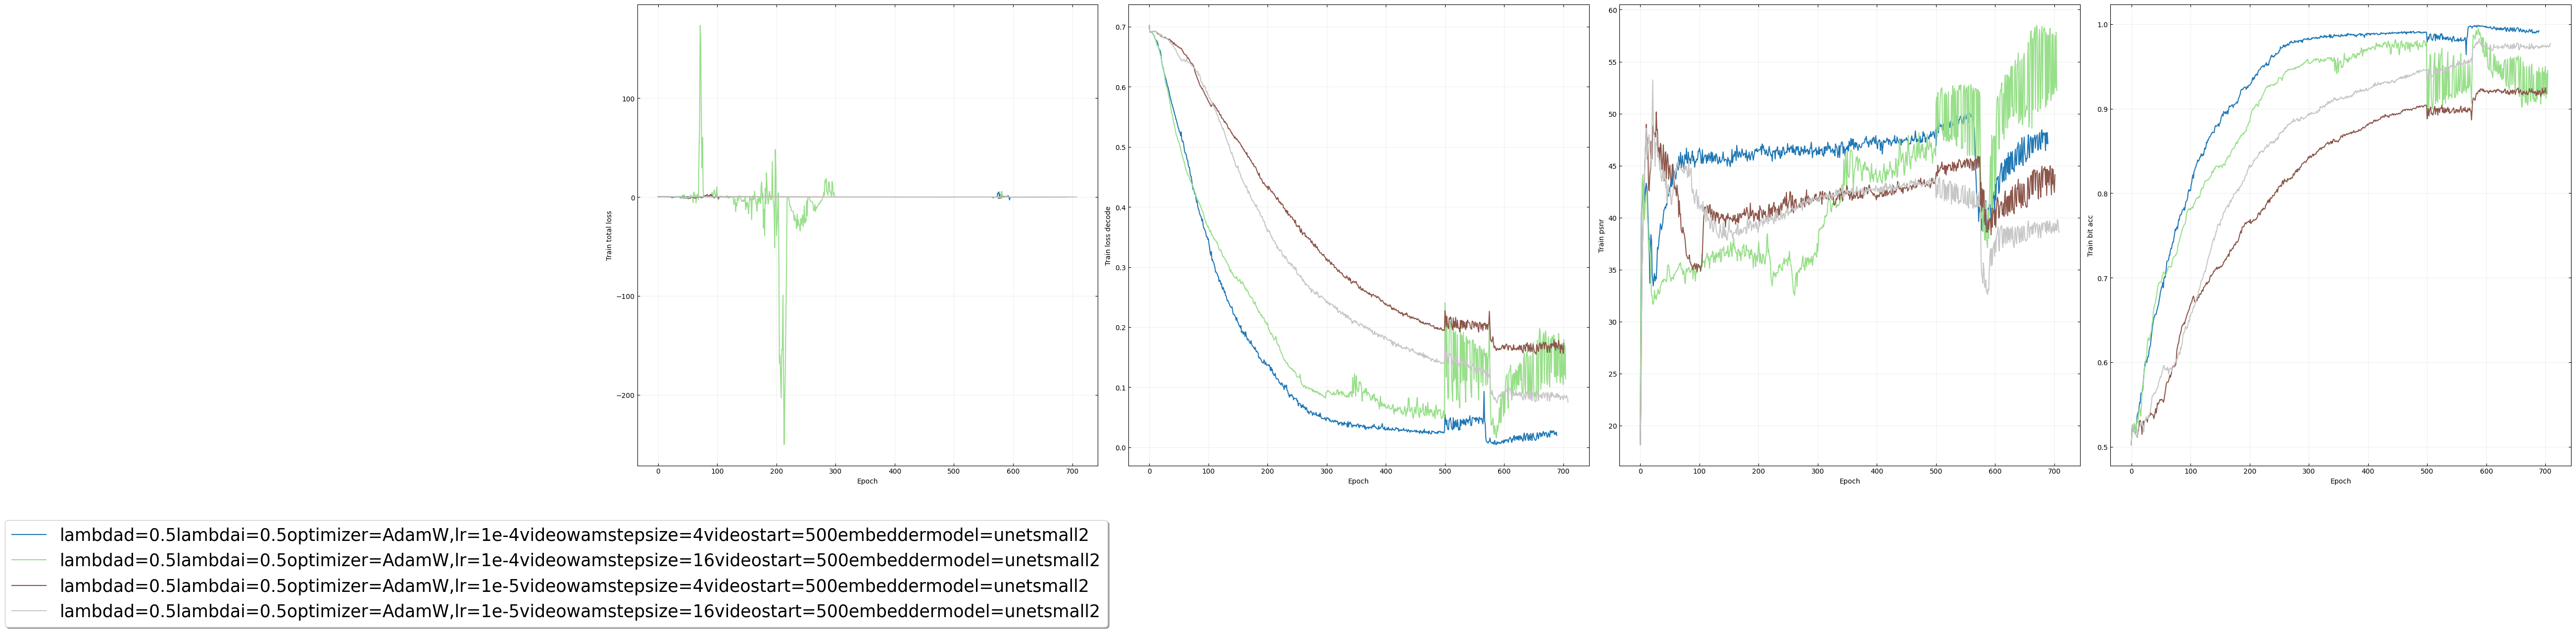

In [7]:
from matplotlib.cm import get_cmap
# all_exp_dir = "/private/home/hadyelsahar/work/code/videoseal/2024_logs/1013-hybrid-large-sweep-allaugs-largembit"
# all_exp_dir = "/private/home/hadyelsahar/work/code/videoseal/2024_logs/1013-hybrid-large-sweep-allaugs"
all_exp_dir = "/private/home/hadyelsahar/work/code/videoseal/2024_logs/1016-hybrid-vs-ours"
filters = {}

params = read_params(os.path.join(all_exp_dir, 'params.txt'))

paths = filter_paths(params, filters)

params = read_params(os.path.join(all_exp_dir, 'params.txt'))

sweepable = sweepable_params(params)

for k, v in sweepable.items():
    print(f"{k}: {v}")

dfs = {}
for path in paths:
    exp_dir = os.path.join(all_exp_dir, path)
    try:
        logs = parse_logs(os.path.join(exp_dir, 'log.txt'), '')
        dfs[path] = pd.DataFrame.from_dict(logs).transpose()
    except FileNotFoundError:
        print(f"{path} is not found")

criteria = [('train_bit_acc', '>', 0.9), ('train_psnr', '>', 38), ('train_ssim', '>', 0.95)]
# criteria = [('train_bit_acc', '>', 0.6), ('train_psnr', '>', 30)]

dfs = filter_dataframes(dfs, criteria, mean_over_last=5)
colormap = get_cmap('tab20')
num_colors = len(dfs)
colors = [colormap(i / num_colors) for i in range(num_colors)]
def plot_measure(dfs, params, measures, title=None):
    ncols = min(8, len(measures))
    nrows = (len(measures) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))
    axes = axes.flatten()
    
    for ii, (path, df) in enumerate(dfs.items()):
        param = params[path]
        for jj, measure in enumerate(measures):
            if jj >= len(axes):
                break
            ax = axes[jj]
            df = df.dropna(subset=[measure])
            ax.plot(df['epoch'], df[measure], label=path.replace('_', ''), color=colors[ii])
            ax.set_ylabel(measure.replace('_', ' ').capitalize())
            ax.set_xlabel('Epoch')
            ax.grid(True)
    
    if title:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    axes[0].legend(loc='upper right', bbox_to_anchor=(1.04, -0.1), fontsize=25, ncol=1, fancybox=True, shadow=True)
    plt.show()
measures = ['train_total_loss', 'train_loss_decode', 'train_psnr', 'train_bit_acc']
plot_measure(dfs, params, measures)

In [8]:
import pandas as pd
from IPython.display import display, HTML

def display_augmented_averages(dfs, prefix_list, show_only_list=None):
    """
    Calculates and displays the average of the last 5 values of each column for each DataFrame in the dictionary,
    focusing on columns that match the given prefixes and averaging them into new columns.
    It also removes the original columns that were averaged. Additionally, it filters columns based on a list of substrings.
    Args:
    dfs (dict): Dictionary where keys are identifiers and values are pandas DataFrames.
    prefix_list (list of tuples): Each tuple contains the regex pattern for the columns and the new column name.
    show_only_list (list of str): List of substrings used to filter columns before processing.
    """
    # Prepare data for display
    averages = {}
    for key, df in dfs.items():
        # Filter columns based on show_only_list if provided
        if show_only_list:
            df = df[[col for col in df.columns if any(sub in col for sub in show_only_list)]].copy()
        for prefix, new_col_name in prefix_list:
            # Filter columns that match the specific pattern
            filtered_columns = df.filter(regex=prefix)
            # Calculate the mean of the last 5 values for these columns
            if not filtered_columns.empty:
                df[new_col_name] = filtered_columns.tail(5).mean(axis=1).mean()
                df = df.drop(columns=filtered_columns.columns)  # Drop the filtered columns
        # Calculate the mean of the last 5 values for the remaining columns
        averages[key] = df.tail(5).mean()
    # Create a DataFrame from the averages dictionary
    averages_df = pd.DataFrame(averages).T  # Transpose to get DataFrames as rows and columns as metrics
    # Display the DataFrame
    return averages_df

prefixes = [
    (r'^val_vid_bit_acc_mask=0_aug=', 'valid augmentation acc'),
    (r'^val_img_bit_acc_mask=', 'valid image augmentation acc'),
]
show_only = ['ssim',"psnr", "acc"]
averages_df = display_augmented_averages(dfs, prefixes, show_only)
averages_df["to_sort_with"] = averages_df["train_psnr"]*averages_df["valid augmentation acc"]
html = averages_df.sort_values(["to_sort_with"], ascending=[0]).to_html()
display(HTML(html))
open("results.html","w").write(html)




,train_psnr,train_ssim,train_bit_acc,val_img_psnr,val_img_ssim,val_vid_psnr,val_vid_ssim,valid augmentation acc,valid image augmentation acc,to_sort_with
"_lambda_d=0.5_lambda_i=0.5_optimizer=AdamW,lr=1e-4_videowam_step_size=16_video_start=500_embedder_model=unet_small2",54.522508,0.998824,0.933343,53.284271,0.998747,53.888332,0.998640,0.833770,0.812602,45.459254
"_lambda_d=0.5_lambda_i=0.5_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=500_embedder_model=unet_small2",47.399699,0.995409,0.991451,45.234402,0.993461,45.514445,0.993068,0.873487,0.859485,41.403044
"_lambda_d=0.5_lambda_i=0.5_optimizer=AdamW,lr=1e-5_videowam_step_size=4_video_start=500_embedder_model=unet_small2",43.502478,0.993857,0.920692,43.040262,0.993983,44.020765,0.995136,0.828529,0.819744,36.043064
"_lambda_d=0.5_lambda_i=0.5_optimizer=AdamW,lr=1e-5_videowam_step_size=16_video_start=500_embedder_model=unet_small2",39.141900,0.980762,0.974357,38.128504,0.978988,38.571888,0.975045,0.867939,0.855987,33.972783


2026

In [5]:
import pandas as pd
from IPython.display import display, HTML
import re

def parse_index(index_str):
    """ Parse the index string into a dictionary of parameters and their values using regex to handle underscores in values. """
    # Regex to find patterns like "key=value"
    pattern = re.compile(r'([^_]+=[^_]+(?:_[^_=]+)*)')
    parts = pattern.findall(index_str)
    params = {}
    for part in parts:
        key, value = part.split('=', 1)
        params[key] = value
    return params
def generate_comparison_dfs(df):
    """ Generate a list of DataFrames for 1-vs-1 comparison of parameter values. """
    # Parse the DataFrame index to get parameters
    params_dicts = [parse_index(idx) for idx in df.index]
    unique_params = set(key for d in params_dicts for key in d.keys())
    
    comparison_results = []
    
    # Create a DataFrame from the parsed parameters
    params_df = pd.DataFrame(params_dicts, index=df.index)
    df = pd.concat([df, params_df], axis=1)
    
    # For each parameter, create a comparison DataFrame
    for param in unique_params:
        if df[param].nunique() > 1:  # Ensure there are at least two unique values to compare
            grouped = df.groupby(param).mean()  # Compute mean for each value of the parameter
            comparison_results.append(grouped)
    
    return comparison_results
def display_comparisons(comparison_dfs):
    """ Display each comparison DataFrame in HTML format in the notebook. """
    for df in comparison_dfs:
        display(HTML(df.to_html()))
# Example usage:

index = [
    '_lambda_d=0.0_lambda_i=0.5_optimizer=AdamW,lr=1e-4_prop_img_vid=0.9_videowam_step_size=4_video_start=500_embedder_model=unet_small2',
]
df = pd.DataFrame(averages_df, index=index)
comparison_dfs = generate_comparison_dfs(df)
display_comparisons(comparison_dfs)

In [6]:
epoch = 95
figsize = (10, 5)
for exp_key in paths:
    print(exp_key)
    try:
        path_img_o = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_0_ori.png"
        path_img_w = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_1_w.png"
        path_img_aug = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_3_aug.png"

        img_o = Image.open(path_img_o)
        img_w = Image.open(path_img_w)
        img_aug = Image.open(path_img_aug)
        crop_size = (256 * 2 + 4, 256 * 2 + 4)
        visu_diff(img_o, img_w, title=f"exp: {exp_key} - Epoch {epoch} - Ori / WM", figsize=figsize, hori=True, crop=crop_size)
        
        # mask = Image.open(path_mask)
        # pred = Image.open(path_pred) 
        # # threshold pred 
        # pred = np.array(pred)
        # pred[pred<128] = 0
        # pred[pred>=128] = 255
        # pred = Image.fromarray(pred)
        # visu_diff(mask, pred, title=f"exp: {exp_key} - Epoch {epoch} - Mask / Pred", figsize=figsize, hori=True, crop=crop_size)
        
        val = Image.open(path_val)
        plt.figure(figsize=(3, 3))
        plt.imshow(val)
        plt.title('Validation')
        plt.tight_layout()
        plt.show()
    except:
        print(f"{exp_key} is not found")
        continue

_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=hidden
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=hidden is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=unet_small2
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=unet_small2 is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=unet_very_tiny
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=unet_very_tiny is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=vae_very_tiny
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,lr=1e-4_videowam_step_size=4_video_start=0_embedder_model=vae_very_tiny is not found
_lambda_d=0.0_lambda_i=0.0_optimizer=AdamW,l

In [ ]:
all_exp_dir = "/checkpoint/pfz/2024_logs/0910_vseal_nopercep_unet"
filters = {
}

# load params and filter
params = read_params(os.path.join(all_exp_dir, 'params.txt'))
paths = filter_paths(params, filters)

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f"{k}: {v}")

# load dataframes
dfs = {}
list_scaling = []
for ii, path in enumerate(paths):
    exp_dir = os.path.join(all_exp_dir, path)
    param = params[path]
    try:
        logs = parse_logs(os.path.join(exp_dir, 'log.txt'), '')
        dfs[path] = pd.DataFrame.from_dict(logs).transpose()
    except:
        print(f"{path} is not found")

paths = dfs.keys()
try:
    epoch = max(dfs[path]['epoch'])
except:
    epoch=0
epoch = int(epoch - epoch % 5)
max_epoch = 2000

# 20 different colors
colors = plt.cm.tab20.colors
# colors = [ plt.cm.tab20.colors[2*ii] for ii in range(3) ] + [ plt.cm.tab20.colors[2*ii+1] for ii in range(3) ] 

def remove_outliers(df, measure):
    Q1 = df[measure].quantile(0.25)
    Q3 = df[measure].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[measure] >= lower_bound) & (df[measure] <= upper_bound)]

def plot_measure(measures, title=None):
    if len(measures) > 8:
        ncols = 8
        nrows = (len(measures) + 7) // 8  # Calculate the number of rows needed
    else:
        ncols = len(measures)
        nrows = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    for ii, path in enumerate(paths):
        df = dfs[path]
        param = params[path]
        for jj, measure in enumerate(measures):
            try:
                ax = axes[jj]
            except IndexError:
                continue  # Skip if there are more measures than axes available
            df = df.dropna(subset=[measure])
            # df = remove_outliers(df, measure)
            ax.plot(df['epoch'][:max_epoch], df[measure][:max_epoch], 
                    label=f"{path.replace('_', '')}" ,
                    # label=
                    #     f"lambda_i:{param['lambda_i']}, " +
                    #     f"lambda_d:{param['lambda_d']}, " +
                    #     f"embedder:{param['embedder_model']}, " +
                    #     f"scaling_w:{param['scaling_w']}",
                    color=colors[ii],
                    )
                    # label=f"{path.replace('_', '')}")
            ylabel = measure.replace('_', ' ').capitalize()
            if 'acc' in ylabel: 
                ax.set_ylim(0.5, 1.01)
            ax.set_ylabel(ylabel)
            xlabel = 'Epoch'
            ax.set_xlabel(xlabel)
            ax.grid(True)
    if title is not None:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    ax.legend(loc='upper right', bbox_to_anchor=(1.04, -0.1), fontsize=16, ncol=1, fancybox=True, shadow=True)
    plt.show()
    

measures = ['train_total_loss', 'train_loss_decode', 'train_psnr', 'train_bit_acc']
plot_measure(measures)

measures = ['val_bit_acc_mask=0_aug=identity_0', 'val_bit_acc_mask=0_aug=crop_0.75', 'val_bit_acc_mask=0_aug=jpeg_60']
plot_measure(measures)

# augs = ["brightness_0.5", "brightness_1.5", "contrast_0.5", "contrast_1.5", "saturation_0.5", "saturation_1.5", "hue_-0.5", "hue_-0.25", "hue_0.25", "hue_0.5", "jpeg_40", "jpeg_60", "jpeg_80", "gaussianblur_3", "gaussianblur_5", "gaussianblur_9", "gaussianblur_17", "medianfilter_3", "medianfilter_5", "medianfilter_9", "medianfilter_17", "rotate_10", "rotate_30", "rotate_45", "rotate_90", "resize_0.5", "resize_0.75", "crop_0.5", "crop_0.75", "perspective_0.2", "perspective_0.5", "perspective_0.8", "horizontalflip_0"]
# measures = [f"val_bit_acc_mask=1_aug={aug}" for aug in augs]
# plot_measure(measures, title='Validation Bit Accuracy')

# augs = ["brightness_0.5", "brightness_1.5", "contrast_0.5", "contrast_1.5", "saturation_0.5", "saturation_1.5", "hue_-0.5", "hue_-0.25", "hue_0.25", "hue_0.5", "jpeg_40", "jpeg_60", "jpeg_80", "gaussianblur_3", "gaussianblur_5", "gaussianblur_9", "gaussianblur_17", "medianfilter_3", "medianfilter_5", "medianfilter_9", "medianfilter_17", "rotate_10", "rotate_30", "rotate_45", "rotate_90", "resize_0.5", "resize_0.75", "crop_0.5", "crop_0.75", "perspective_0.2", "perspective_0.5", "perspective_0.8", "horizontalflip_0"]
# measures = [f"val_miou_mask=1_aug={aug}" for aug in augs]
# plot_measure(measures, title='Validation IoU')

## minimal reprod

In [ ]:
all_exp_dir = "/checkpoint/pfz/2024_logs/hidden_minimal"
# all_exp_dir = "/checkpoint/pfz/2024_logs/hidden_minimal_balanced"
filters = {
}

# load params and filter
params = read_params(os.path.join(all_exp_dir, 'params.txt'))
paths = filter_paths(params, filters)

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f"{k}: {v}")

# load dataframes
dfs = {}
list_scaling = []
for ii, path in enumerate(paths):
    exp_dir = os.path.join(all_exp_dir, path)
    param = params[path]
    try:
        logs = parse_logs(os.path.join(exp_dir, 'log.txt'), '')
        dfs[path] = pd.DataFrame.from_dict(logs).transpose()
    except:
        print(f"{path} is not found")

paths = dfs.keys()
try:
    epoch = max(dfs[path]['epoch'])
except:
    epoch=0
epoch = int(epoch - epoch % 5)
max_epoch = 2000

# 20 different colors
colors = plt.cm.tab20.colors
# colors = [ plt.cm.tab20.colors[2*ii] for ii in range(3) ] + [ plt.cm.tab20.colors[2*ii+1] for ii in range(3) ] 

def remove_outliers(df, measure):
    Q1 = df[measure].quantile(0.25)
    Q3 = df[measure].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[measure] >= lower_bound) & (df[measure] <= upper_bound)]

def plot_measure(measures, title=None, ncols=5):
    if len(measures) > ncols:
        ncols = ncols
        nrows = (len(measures) + ncols-1) // ncols  # Calculate the number of rows needed
    else:
        ncols = len(measures)
        nrows = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    for ii, path in enumerate(paths):
        df = dfs[path]
        param = params[path]
        for jj, measure in enumerate(measures):
            try:
                ax = axes[jj]
            except IndexError:
                continue  # Skip if there are more measures than axes available
            df = df.dropna(subset=[measure])
            # df = remove_outliers(df, measure)
            ax.plot(df['epoch'][:max_epoch], df[measure][:max_epoch], 
                    label=f"{path.replace('_', '')}" ,
                    # label=
                    #     f"lambda_i:{param['lambda_i']}, " +
                    #     f"lambda_d:{param['lambda_d']}, " +
                    #     f"embedder:{param['embedder_model']}, " +
                    #     f"scaling_w:{param['scaling_w']}",
                    color=colors[ii],
                    )
                    # label=f"{path.replace('_', '')}")
            ylabel = measure.replace('_', ' ').capitalize()
            if 'acc' in ylabel: 
                ax.set_ylim(0.5, 1.01)
            ax.set_ylabel(ylabel)
            xlabel = 'Epoch'
            ax.set_xlabel(xlabel)
            ax.grid(True)
    if title is not None:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    ax.legend(loc='upper right', bbox_to_anchor=(1.04, -0.1), fontsize=16, ncol=1, fancybox=True, shadow=True)
    plt.show()
    

measures = ['train_total_loss', 'train_loss_percep', 'train_loss_disc', 'train_loss_decode', 'train_scale_percep', 'train_scale_disc', 'train_scale_decode', 'train_psnr', 'train_bit_acc']
plot_measure(measures)

measures = ['val_bit_acc_mask=0_aug=identity_0', 'val_bit_acc_mask=0_aug=crop_0.5', 'val_bit_acc_mask=0_aug=horizontalflip_0']
plot_measure(measures)

# augs = ["brightness_0.5", "brightness_1.5", "contrast_0.5", "contrast_1.5", "saturation_0.5", "saturation_1.5", "hue_-0.5", "hue_-0.25", "hue_0.25", "hue_0.5", "jpeg_40", "jpeg_60", "jpeg_80", "gaussianblur_3", "gaussianblur_5", "gaussianblur_9", "gaussianblur_17", "medianfilter_3", "medianfilter_5", "medianfilter_9", "medianfilter_17", "rotate_10", "rotate_30", "rotate_45", "rotate_90", "resize_0.5", "resize_0.75", "crop_0.5", "crop_0.75", "perspective_0.2", "perspective_0.5", "perspective_0.8", "horizontalflip_0"]
# measures = [f"val_bit_acc_mask=1_aug={aug}" for aug in augs]
# plot_measure(measures, title='Validation Bit Accuracy')

# augs = ["brightness_0.5", "brightness_1.5", "contrast_0.5", "contrast_1.5", "saturation_0.5", "saturation_1.5", "hue_-0.5", "hue_-0.25", "hue_0.25", "hue_0.5", "jpeg_40", "jpeg_60", "jpeg_80", "gaussianblur_3", "gaussianblur_5", "gaussianblur_9", "gaussianblur_17", "medianfilter_3", "medianfilter_5", "medianfilter_9", "medianfilter_17", "rotate_10", "rotate_30", "rotate_45", "rotate_90", "resize_0.5", "resize_0.75", "crop_0.5", "crop_0.75", "perspective_0.2", "perspective_0.5", "perspective_0.8", "horizontalflip_0"]
# measures = [f"val_miou_mask=1_aug={aug}" for aug in augs]
# plot_measure(measures, title='Validation IoU')

In [ ]:
epoch = 50
figsize = (10, 5)
for exp_key in paths:
    print(exp_key)
    try:
        path_img_o = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_0_ori.png"
        path_img_w = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_1_w.png"
        path_img_aug = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_3_aug.png"
        path_mask = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_4_mask.png"
        path_pred = f"{all_exp_dir}/{exp_key}/{epoch:03d}_000_train_5_pred.png"
        path_val = f"{all_exp_dir}/{exp_key}/{epoch:03d}_val_full.png"

        img_o = Image.open(path_img_o)
        img_w = Image.open(path_img_w)
        img_aug = Image.open(path_img_aug)
        crop_size = (256 * 2 + 4, 256 * 2 + 4)
        visu_diff(img_o, img_w, title=f"exp: {exp_key} - Epoch {epoch} - Ori / WM", figsize=figsize, hori=True, crop=crop_size)
        
        # mask = Image.open(path_mask)
        # pred = Image.open(path_pred) 
        # # threshold pred 
        # pred = np.array(pred)
        # pred[pred<128] = 0
        # pred[pred>=128] = 255
        # pred = Image.fromarray(pred)
        # visu_diff(mask, pred, title=f"exp: {exp_key} - Epoch {epoch} - Mask / Pred", figsize=figsize, hori=True, crop=crop_size)
        
        val = Image.open(path_val)
        plt.figure(figsize=(3, 3))
        plt.imshow(val)
        plt.title('Validation')
        plt.tight_layout()
        plt.show()
    except:
        print(f"{exp_key} is not found")
        continue